In [1]:
# Basic math libraries
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
import pickle
from matplotlib.colors import ListedColormap

# Matrix eigendecomposition
import numpy.linalg as lg
import scipy.linalg as slg

# Networks and Graphs
import networkx as nx
import dynetx as dn

# Random data generation
import itertools
import random
from collections import Counter
from random import randint
from itertools import chain
import time

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

%load_ext autoreload
%autoreload 2

# Import Network

In [2]:
# Import the multilayer dynamic network from file

L_file = np.load("datasets/outputs/multilayer_dynamic_network_500.npy", allow_pickle=True)
L_file = [[L_file[t][s] for s in range(len(L_file[0]))] for t in range(len(L_file))]


# Import node position to be used for all plots

pos_name = "kamada_kawai"
pos = np.load("datasets/nodes position for plot/position_network_" + pos_name + ".npy", allow_pickle=True).item()

In [3]:
# SET GRAPH NUMBERS

N = len(L_file[0][0])                                              # number of nodes
S = len(L_file[0])                                                 # number of layers (dyn + static)
layer_names = ['Hospital', 'Workplace', 'Random', 'School', 'Household']

T_file = len(L_file)
T_periodicity = 2
T = T_file * T_periodicity                                          # number of days 
L = L_file * T_periodicity

print("T =", T, "\nS =", S, "\nN =", N)

T = 56 
S = 5 
N = 500


In [4]:
# SET COVID NUMBERS

infection_threshold = 0.8                                     # signal value over which a person is considered sick
max_sickness_duration = 10                                    # days of maximum duration of the illness
min_immunization_duration = 60                                # days of immunization after having taken the virus


# import real covid cases and take the first T days
covid_cases = list(np.load("datasets/inputs/AI_covid_cases.npy", allow_pickle=True))[:T]

### Laplacian aggregation

just for representation purposes.

In [5]:
# function Phi to aggregate the layers as weighted sum

def phi(list_like, weights = None):                                   
    if weights is None and isinstance(list_like, torch.Tensor):
        weights = torch.ones(len(list_like))
    elif weights is None and isinstance(list_like, list):
        weights = np.ones(len(list_like))
    summ = []
    for s in range(S):
        summ.append(list_like[s]*weights[s])
    return sum(summ) / sum(weights)


# function to build a graph given a laplacian matrix

def graph_from_laplacian(L):
    A = -L
    np.fill_diagonal(A, 0)
    A_ = np.maximum(A, 0)
    G = nx.from_numpy_matrix(A_)
    return G


# function to draw a network with weighted edges

def show_network(G, weighted=False, pos=None, ax=None, figsize=(5,5), node_color='b'):
    if ax is None:
        plt.figure(figsize=figsize)
        plt.axis('off')
        ax = plt.gca()
    if pos is None:
        pos = nx.spring_layout(G) 
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = tuple(w*10 for w in weights)     # maybe useless
    emap = plt.cm.Greys if weighted else ListedColormap([(0,0,0)])
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color, ax=ax) # cmap=MyCmap,
    nx.draw_networkx_edges(G, pos, width=0.5, edgelist=edges, edge_color=weights, edge_cmap=emap, ax=ax) #alpha=2, ax=ax)

In [6]:
# Create aggregated laplacian L_agg, with more weights on the dynamic layers

weights_initialitazion = np.array( [1,1,0.5,0.5,1] )
L_agg = []
for t in range(T):
    L_agg.append(phi(L[t], weights = weights_initialitazion))

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


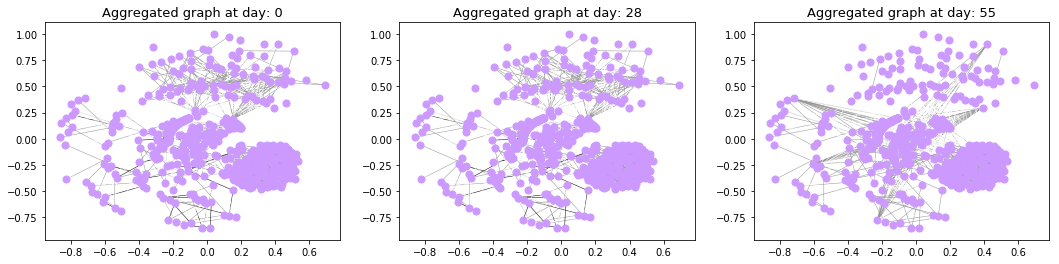

In [7]:
# Create aggregated graph G_agg

G_agg = [graph_from_laplacian(L_agg[t]) for t in range(T)]
pos_agg = pos #nx.spring_layout(G_agg[0])


# Plot temporal evolution of G_agg

T_display = 2 #4
days_to_display = [round(i*T/T_display) for i in range(T_display)]+[T-1]
fig, axes = plt.subplots(nrows=1, ncols=len(days_to_display), figsize = [18, 4])
ax = axes.flatten() 
node_color = '#CC99FF'
for idx, t in enumerate(days_to_display): 
    show_network(G_agg[t], weighted = True, pos=pos_agg, ax = ax[idx], node_color=node_color)
    ax[idx].set_title("Aggregated graph at day: "+str(t), fontsize=13)
plt.show()

In [8]:
# Save the AGGREGATED dynamic network in a .npy file as 3D numpy array

np.save("datasets/outputs/aggregated_dynamic_network.npy", L_agg)

# Signal inference problem

## T_0 signal

In [9]:
# Function to homogenize by window of lenght 3 the number of cases when loaded from online data

def homogenize_cases(cases_list):
    homogenized_cases = []
    for idx, val in enumerate(cases_list):
        if idx == 0 or idx == len(cases_list)-1:
            homogenized_cases.append(val)
        else:
            homogenized_cases.append( round(0.25*cases_list[idx-1] + 0.50*cases_list[idx] + 0.25*cases_list[idx+1]) )
    return homogenized_cases

In [10]:
# COVID DATA PREPARATION 

# homogenize the number of cases to adjust eventual test delays, and out only 1 case as starting diffusion point
numer_of_known_cases_day_by_day = homogenize_cases(covid_cases)
numer_of_known_cases_day_by_day[0] = 1

# # ALTERNATIVE: RANDOM GENERATION based on number of nodes N
# numer_of_known_cases_day_by_day = np.sort([randint(1, N) for p in range(0, T)]+[1])[0:T]
# numer_of_known_cases_day_by_day = [3,3,4,6,6,9,12,14,19,20,25,30, 34, 39, 40, 46, 52, 61, 74]

In [11]:
# First day signal

infected_t0 = random.sample(range(N), numer_of_known_cases_day_by_day[0])  
signal_t0 = np.zeros(N)
signal_t0[infected_t0] = 1    

print("Number of cases along ", T, " days: \n", numer_of_known_cases_day_by_day,
      "\n\nFirst nodes infected (at time t0): \n", infected_t0)

Number of cases along  56  days: 
 [1, 2, 4, 5, 5, 6, 6, 6, 6, 6, 8, 9, 11, 12, 13, 13, 14, 14, 16, 18, 20, 21, 21, 21, 22, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25] 

First nodes infected (at time t0): 
 [484]


## T_1,...T_n signals

The following process learns the best parameter tau for each combination of filters heat/normal/highpass in each layer. To learn the optimal combination and parameters, the class Learn_filter minimizes the temporal sum of:
  
\begin{equation}
abs( calculated\_n\_cases[t] - numer\_of\_known\_cases[t] )
\end{equation}

and returns the best filter with the best parameters. 

To unburden the computation, we decide to split the choice of the filter family and the learning of the parameters. Using the same algorithm, we first learn which family better describe the evolution of dynamic and static layers <b>over a smaller subset of layers</b> (eventually reducing the number of epochs). Then, fixed the filter families, we will learn the best tau parameters with a complete learning over all layers.

3 families of filters can be applied over the eigenvalues of each laplacian-layer (that arrives already regularized):
- HEAT with parameters tau
- NORMAL without parameters
- HIGHPASS with parameters tau

In [12]:
class Learn_Filter: 
    
    def __init__(self, epochs, lr):
        self.epochs = epochs
        self.lr     = lr
        
    def fit(self, tau, kind_of_filter, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L, print_epochs_each=25): 
        self.setup(tau, kind_of_filter, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L)
        self.train(print_epochs_each=25)                                   

    def setup(self, tau, kind_of_filter, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L):                                    
        self.tau = torch.from_numpy(tau.astype(np.float32)).requires_grad_()
        self.kind_of_filter = kind_of_filter
        self.infection_threshold = torch.tensor(infection_threshold)
        self.numer_of_known_cases_day_by_day = torch.tensor(numer_of_known_cases_day_by_day)
        self.signal_t0 = torch.from_numpy(signal_t0.astype(np.float32))
        self.L = [   [  torch.from_numpy(L[t][s].astype(np.float32)) for s in range(S)   ]  for t in range(T) ]
       
    def loss(self): 
        sum_loss = 0  
        signal_time = [self.signal_t0]
        sigmoid = nn.Sigmoid()

        for t in range(T):
            signal_time_t = self.NN_multilayer_evolution(signal_time, t)
            signal_time.append(signal_time_t)
            
            # Convert signal_time_t to bool without loosing gradient
            stretched = (signal_time_t-self.infection_threshold)*10000
            boolean = sigmoid(stretched)
            error = abs(torch.sum(boolean) - self.numer_of_known_cases_day_by_day[t])
            
            sum_loss += error
        return sum_loss
                      
    def train(self, print_epochs_each):
        optimizer = torch.optim.Adam( [self.tau], lr=self.lr, amsgrad=True) 
        self.history = []
        time_wait = 0
        old_loss = 0
        for epoch in range(self.epochs+1):
            loss = self.loss()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            self.history.append(loss.detach().item())            
            if epoch == 0 or epoch % print_epochs_each == 0:
                print('\nEpoch {:4d}/{:d}: {:2.2f}'.format(epoch, self.epochs, loss.item()))  
                print('Learning tau :', (self.tau).detach().numpy()) 
                
            # stop when loss is very small for more than 10 epochs
            if abs(loss.item()-old_loss) < 0.01:
                time_wait +=1
            if time_wait >= 10:
                print("Stop: loss no longer decreases")
                print('\nEpoch {:4d}/{:d}: {:2.2f}'.format(epoch, self.epochs, loss.item()))  
                print('Learning tau :', (self.tau).detach().numpy())
                break
            old_loss = loss.detach().item()
    
    def learned_tau(self):
        return (self.tau).detach().numpy()

    
#------------------------------Functions to calculate the filtering, converted to Torch------------------------------------------------
    
    def NN_h_filter(self, tau_nn, laplacian, kind_of_filter): 
        eigenvalues , eigenvectors = torch.eig(laplacian, eigenvectors = True)
        eigenvalues = eigenvalues[:, 0]
        if kind_of_filter == "heat":
            heat_diag = torch.exp(-eigenvalues*tau_nn)
            H_filter = torch.diag(heat_diag)
            h_filter = torch.matmul (torch.matmul(eigenvectors, H_filter) , eigenvectors.T)   
        elif kind_of_filter == "normal":                               # no tau to learn
            alpha = 0.01
            eigenv = torch.diag(eigenvalues) + alpha * torch.eye(len(eigenvalues)) 
            pseudo_inv = torch.inverse(eigenv)                             
            evals, evecs = torch.eig(pseudo_inv, eigenvectors = True)  # eigendecomposition to calculate matricial sqrt with torch
            evals = evals[:, 0]  
            square_root = torch.matmul(evecs, torch.matmul(torch.diag(evals**(-1/2)), torch.inverse(evecs)))  
            square_root = square_root + tau_nn*0                       # workaround
            h_filter = torch.matmul( torch.matmul(eigenvectors, square_root) , eigenvectors.T) 
        elif kind_of_filter == "highpass":
            alpha = 0.01 
            numerator = torch.diag(eigenvalues)*tau_nn
            denominator = torch.inverse(torch.diag( torch.exp(-(eigenvalues+1)*tau_nn) )+ alpha * torch.eye(len(eigenvalues)) )
            H_filter = torch.matmul(numerator,denominator)
            h_filter = torch.matmul( torch.matmul(eigenvectors, H_filter) , eigenvectors.T)     
        return h_filter

    def NN_single_layer_evolution(self, tau_nn, input_signal, kind_of_filter, L):

        filtered_signal = torch.matmul( self.NN_h_filter(tau_nn, L, kind_of_filter), input_signal) 
        min_v = torch.min(filtered_signal)
        max_v = torch.max(filtered_signal)
        if min_v==max_v:       # to avoid denominator=0 that gives NaN
            normalized_signal = (filtered_signal - min_v)
        else:
            normalized_signal = (filtered_signal - min_v) / (max_v-min_v)   
        return normalized_signal   
    

    def NN_multilayer_evolution(self, signal_multilayer_temporal, t):        
        
        signal_multilayer = []
        
        for s in range(S):

            signal_layer = self.NN_single_layer_evolution(self.tau[s], signal_multilayer_temporal[t], self.kind_of_filter[s], self.L[t][s])  
            signal_multilayer.append(signal_layer)
            
        for n in range(N):
            
            # Select the worst health status of the person over all layers
            max_value =  max( [signal_multilayer[l][n] for l in range(S)] )           
            if n == 0:
                max_signal =  torch.unsqueeze(max_value, 0)
            else:    
                max_signal = torch.cat((max_signal, torch.unsqueeze(max_value, 0)), dim=0) 
                               
            # One cannot be infectuous for more than tot. days (tot.= max_sickness_duration)
            if t>max_sickness_duration and signal_multilayer_temporal[t-max_sickness_duration+1][n] > self.infection_threshold:
                max_value = 0 
            
            # After having COVID, one is immune for at least tot. days (tot.= min_immunization_duration)
            if t>min_immunization_duration \
            and any([signal_multilayer_temporal[t-i][n]>self.infection_threshold for i in range(min_immunization_duration)]) \
            and signal_multilayer_temporal[t][n] < self.infection_threshold: 
                max_value = 0 
                
        return max_signal

### Learn family of filters

This heavy learnining tries any combination of filters heat-normal-highpass in the layers and, optimizing the diffusion parameter tau for each one, calculate all the losses so that we can chose the combination givign minimum loss to define the signal over the graph. THis combination is the one that better represent the aggregated (covid) data as combination of diffusion processes over each layer.

In [14]:
# Learn the filters that better define a diffusion coherent with the real number of COVID cases

# change T value to make the experiment over less timestamps (to save time and computation)
T = T_file


# params
tau_init = np.ones(S)/S
admitted_filters = ["heat", "highpass", "normal"]


# compute combinations of layers and filters, to test them all
filter_combinations = list([p for p in itertools.product(admitted_filters, repeat=S)]) 
print("Number of combinations to train: ", len(filter_combinations))


# train the algorithm for all the combinations; save the loss and tau associated with the filters combination 
tau_outp = []
loss = []
for idx, filters in enumerate(filter_combinations):
    print("\n\n-----------------------------------------------\n\n", (idx+1), "/", len(filter_combinations), " Filters combination: ", filters)    
    net_cases_mix = Learn_Filter(epochs=20, lr=0.1)
    net_cases_mix.fit(tau_init, filters, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L, print_epochs_each=10)
    tau_outp.append(net_cases_mix.learned_tau())
    loss.append(net_cases_mix.history[-1])

Number of combinations to train:  243


-----------------------------------------------

 1 / 243  Filters combination:  ('heat', 'heat', 'heat', 'heat', 'heat')


/home/cozzani/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag



Epoch    0/20: 1117.67
Learning tau : [0.10000002 0.3        0.10000002 0.10000001 0.29999998]


-----------------------------------------------

 2 / 243  Filters combination:  ('heat', 'heat', 'heat', 'heat', 'highpass')

Epoch    0/20: 937.88
Learning tau : [0.10000001 0.10000001 0.29999998 0.10000001 0.1       ]


-----------------------------------------------

 3 / 243  Filters combination:  ('heat', 'heat', 'heat', 'heat', 'normal')

Epoch    0/20: 1034.60
Learning tau : [0.10000001 0.1        0.29999998 0.10000001 0.2       ]


-----------------------------------------------

 4 / 243  Filters combination:  ('heat', 'heat', 'heat', 'highpass', 'heat')

Epoch    0/20: 537.84
Learning tau : [0.10000002 0.1        0.10000001 0.29999998 0.10000005]


-----------------------------------------------

 5 / 243  Filters combination:  ('heat', 'heat', 'heat', 'highpass', 'highpass')

Epoch    0/20: 443.21
Learning tau : [0.10000001 0.1        0.3        0.3        0.3       ]


-------


Epoch    0/20: 668.00
Learning tau : [0.2 0.2 0.2 0.2 0.2]


-----------------------------------------------

 40 / 243  Filters combination:  ('heat', 'highpass', 'highpass', 'highpass', 'heat')

Epoch    0/20: 174.00
Learning tau : [0.2 0.2 0.2 0.2 0.2]


-----------------------------------------------

 41 / 243  Filters combination:  ('heat', 'highpass', 'highpass', 'highpass', 'highpass')

Epoch    0/20: 147.00
Learning tau : [0.2        0.10000001 0.10000001 0.3        0.3       ]


-----------------------------------------------

 42 / 243  Filters combination:  ('heat', 'highpass', 'highpass', 'highpass', 'normal')

Epoch    0/20: 170.01
Learning tau : [0.10000366 0.3        0.10000002 0.1        0.2       ]


-----------------------------------------------

 43 / 243  Filters combination:  ('heat', 'highpass', 'highpass', 'normal', 'heat')

Epoch    0/20: 185.00
Learning tau : [0.2 0.2 0.2 0.2 0.2]


-----------------------------------------------

 44 / 243  Filters combinat



-----------------------------------------------

 78 / 243  Filters combination:  ('heat', 'normal', 'normal', 'highpass', 'normal')

Epoch    0/20: 141.00
Learning tau : [0.2 0.2 0.2 0.2 0.2]


-----------------------------------------------

 79 / 243  Filters combination:  ('heat', 'normal', 'normal', 'normal', 'heat')

Epoch    0/20: 178.00
Learning tau : [0.2       0.2       0.2       0.2       0.2999997]


-----------------------------------------------

 80 / 243  Filters combination:  ('heat', 'normal', 'normal', 'normal', 'highpass')

Epoch    0/20: 188.00
Learning tau : [0.29960796 0.2        0.2        0.2        0.29999888]


-----------------------------------------------

 81 / 243  Filters combination:  ('heat', 'normal', 'normal', 'normal', 'normal')

Epoch    0/20: 146.00
Learning tau : [0.10228361 0.2        0.2        0.2        0.2       ]


-----------------------------------------------

 82 / 243  Filters combination:  ('highpass', 'heat', 'heat', 'heat', 'heat


Epoch    0/20: 776.34
Learning tau : [0.3        0.3        0.10000001 0.2        0.29999998]


-----------------------------------------------

 116 / 243  Filters combination:  ('highpass', 'highpass', 'heat', 'normal', 'highpass')

Epoch    0/20: 542.19
Learning tau : [0.1        0.1        0.10000001 0.2        0.29999998]


-----------------------------------------------

 117 / 243  Filters combination:  ('highpass', 'highpass', 'heat', 'normal', 'normal')

Epoch    0/20: 808.17
Learning tau : [0.3        0.10000002 0.10000001 0.2        0.2       ]


-----------------------------------------------

 118 / 243  Filters combination:  ('highpass', 'highpass', 'highpass', 'heat', 'heat')

Epoch    0/20: 405.00
Learning tau : [0.29999998 0.3        0.1        0.3        0.10000002]


-----------------------------------------------

 119 / 243  Filters combination:  ('highpass', 'highpass', 'highpass', 'heat', 'highpass')

Epoch    0/20: 318.00
Learning tau : [0.19652414 0.20363317 0


Epoch    0/20: 207.00
Learning tau : [0.2993962  0.2        0.28168184 0.2        0.10746827]


-----------------------------------------------

 152 / 243  Filters combination:  ('highpass', 'normal', 'highpass', 'normal', 'highpass')

Epoch    0/20: 215.00
Learning tau : [0.24330969 0.2        0.16305089 0.2        0.2643523 ]


-----------------------------------------------

 153 / 243  Filters combination:  ('highpass', 'normal', 'highpass', 'normal', 'normal')

Epoch    0/20: 216.01
Learning tau : [0.10020674 0.2        0.1        0.2        0.2       ]


-----------------------------------------------

 154 / 243  Filters combination:  ('highpass', 'normal', 'normal', 'heat', 'heat')

Epoch    0/20: 764.17
Learning tau : [0.29999998 0.2        0.2        0.3        0.10000001]


-----------------------------------------------

 155 / 243  Filters combination:  ('highpass', 'normal', 'normal', 'heat', 'highpass')

Epoch    0/20: 697.00
Learning tau : [0.2 0.2 0.2 0.2 0.2]


----



-----------------------------------------------

 189 / 243  Filters combination:  ('normal', 'heat', 'normal', 'normal', 'normal')

Epoch    0/20: 669.26
Learning tau : [0.2 0.3 0.2 0.2 0.2]


-----------------------------------------------

 190 / 243  Filters combination:  ('normal', 'highpass', 'heat', 'heat', 'heat')

Epoch    0/20: 977.08
Learning tau : [0.2        0.10000002 0.10000001 0.3        0.10000001]


-----------------------------------------------

 191 / 243  Filters combination:  ('normal', 'highpass', 'heat', 'heat', 'highpass')

Epoch    0/20: 943.00
Learning tau : [0.2        0.10000001 0.3        0.10000002 0.1       ]


-----------------------------------------------

 192 / 243  Filters combination:  ('normal', 'highpass', 'heat', 'heat', 'normal')

Epoch    0/20: 969.77
Learning tau : [0.2        0.1        0.10000001 0.3        0.2       ]


-----------------------------------------------

 193 / 243  Filters combination:  ('normal', 'highpass', 'heat', 'hi


Epoch    0/20: 906.35
Learning tau : [0.2        0.2        0.10000001 0.2        0.2       ]


-----------------------------------------------

 226 / 243  Filters combination:  ('normal', 'normal', 'highpass', 'heat', 'heat')

Epoch    0/20: 375.00
Learning tau : [0.2        0.2        0.29999998 0.10000473 0.20999001]


-----------------------------------------------

 227 / 243  Filters combination:  ('normal', 'normal', 'highpass', 'heat', 'highpass')

Epoch    0/20: 306.00
Learning tau : [0.2        0.2        0.20000018 0.19999985 0.2       ]


-----------------------------------------------

 228 / 243  Filters combination:  ('normal', 'normal', 'highpass', 'heat', 'normal')

Epoch    0/20: 374.00
Learning tau : [0.2 0.2 0.2 0.2 0.2]


-----------------------------------------------

 229 / 243  Filters combination:  ('normal', 'normal', 'highpass', 'highpass', 'heat')

Epoch    0/20: 210.00
Learning tau : [0.2        0.2        0.3        0.10000002 0.10024894]


------------

In [15]:
# Take best combination (minimum loss) of filters per each layer

df = pd.DataFrame(filter_combinations, columns = layer_names[:S])
df['Loss'] = [round(x,2) for x in loss]
df['Tau'] = tau_outp
df = df.sort_values(['Loss'])
df.reset_index(inplace=True, drop=True)

print("\nThe filter that better represent each layers are the first line (minimum loss) of:")
df


The filter that better represent each layers are the first line (minimum loss) of:


,Hospital,Workplace,Random,School,Household,Loss,Tau
0,heat,heat,normal,heat,normal,102.00,"[0.7807303, 0.90613365, 0.2, -0.21097979, 0.2]"
1,highpass,heat,highpass,normal,normal,104.48,"[0.13644259, 0.14948837, 0.8298372, 0.2, 0.2]"
2,heat,heat,normal,highpass,normal,109.00,"[0.2, 0.2, 0.2, 0.2, 0.2]"
3,heat,normal,heat,heat,normal,109.06,"[0.47832683, 0.2, -0.79365677, -0.13142939, 0.2]"
4,heat,normal,heat,normal,heat,114.89,"[0.11371726, 0.2, -0.64041525, 0.2, 1.0384967]"
...,...,...,...,...,...,...,...
238,highpass,heat,heat,highpass,highpass,5480.29,"[-0.499311, -0.37243032, 0.07331527, 0.5152743..."
239,highpass,highpass,normal,highpass,heat,6089.61,"[-0.5149839, 0.05280293, 0.2, -0.3300148, -0.4..."
240,normal,highpass,heat,highpass,highpass,6578.11,"[0.2, -0.22446346, 0.68057835, -0.58667415, -0..."
241,highpass,heat,normal,highpass,normal,6654.54,"[-0.5252208, 0.607268, 0.2, -0.23734559, 0.2]"


### Learn TAU parameters

In [20]:
# print the chosen filters

kind_of_filter = list(df[layer_names[:S]].iloc[0])       # from the first line of the df
tau = df["Tau"].iloc[0]                                  # from the first line of the df
for s in range(S):
    print(layer_names[s], kind_of_filter[s], tau[s])

Hospital heat 0.7807303
Workplace heat 0.90613365
Random normal 0.2
School heat -0.21097979
Household normal 0.2


In [16]:
# Learn the tau that better define a diffusion coherent with the real number of COVID cases, over all the timestamps


# params initialization

N = len(L_file[0][0]) 
T = T_file * T_periodicity  
print("Train over more epochs to optimize Tau for the filters:\n", kind_of_filter)

# NN creation and learning

net_cases = Learn_Filter(epochs=1000, lr=0.007)
net_cases.fit(tau, kind_of_filter, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L, print_epochs_each=25)
tau = net_cases.learned_tau()

Train over more epochs to optimize Tau for the filters:
 ['heat', 'heat', 'normal', 'heat', 'normal']

Epoch    0/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21097979  0.2       ]

Epoch   25/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21097979  0.2       ]

Epoch   50/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21097979  0.2       ]

Epoch   75/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21097979  0.2       ]

Epoch  100/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21097979  0.2       ]

Epoch  125/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21097979  0.2       ]

Epoch  150/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21097979  0.2       ]

Epoch  175/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21097979  0.2       ]

Epoch  200/1000: 473.00
Learning tau : [ 0.7807303   0.90613365  0.2        -0.21

In [17]:
# Print TAU results

print("The filters and parameters Tau better representing diffusion processes over each layer are:\n")
for i, name in enumerate(layer_names):  
    print(kind_of_filter[i], "filter with Tau =", tau[i], " for layer " + name)

The filters and parameters Tau better representing diffusion processes over each layer are:

heat filter with Tau = 0.7807303  for layer Hospital
heat filter with Tau = 0.90613365  for layer Workplace
normal filter with Tau = 0.2  for layer Random
heat filter with Tau = -0.21097979  for layer School
normal filter with Tau = 0.2  for layer Household


### Generate temporal signal

NEXT DAYS: we generate the next-days signals as filtered version of the initial signal. This imitates a diffusion
over the graph. The filter family have been learned before, here we learn better parameters tau to balance the numer_of_known_cases_day_by_day.
NB: The signals generated like this are destinated to disappear along time, so in the algorithm we constantly rescale to have peaks close to 1.

In [16]:
def h_filter(laplacian, kind_of_filter, tau, **params):
    eigenvalues , eigenvectors = lg.eigh(laplacian)
   
    if kind_of_filter not in ("heat", "normal", "highpass"):
        print("kind_of_filter must be chosen between: normal, heat, highpass")
        return 0

    elif kind_of_filter == "heat":
        heat_diag = [np.exp(-tau*x) for x in eigenvalues]
        H_filter = np.diag(heat_diag)
        h_filter = eigenvectors.dot(H_filter).dot(eigenvectors.T)
   
    elif kind_of_filter == "normal":  
        alpha = 0.01
        eigenv = np.diag(eigenvalues) + alpha * np.eye(len(eigenvalues))  # regularization term, to avoid 0 values in the sqrt
        x_reg = lg.pinv(eigenv)
        h_filter = eigenvectors.dot(slg.sqrtm(x_reg)).dot(eigenvectors.T)
       
    elif kind_of_filter == "highpass":
        numerator = np.diag(eigenvalues)*tau
        denominator = lg.pinv(np.diag( [tau*x+1 for x in eigenvalues] ))
        H_filter = numerator.dot(denominator)
        h_filter = eigenvectors.dot(H_filter).dot(eigenvectors.T)
        
    return h_filter  

In [17]:
# Calculate the next-day signal over the multi layer graph. The inputs L and tau are lists.
# Performs RESCALING of high values (with a threshold) and a limit to SICKNESS DURATION (set to 10 days). 

def single_layer_evolution(input_signal, kind_of_filter, L, tau, infection_threshold, **params):
    filtered_signal = h_filter(L, kind_of_filter, tau, **params).dot(input_signal) 
    new_signal = np.interp(filtered_signal, (filtered_signal.min(), filtered_signal.max()), (0, +1))             
    return np.array(new_signal)      


def multilayer_evolution(input_signal, kind_of_filter, L, tau, infection_threshold, **params):
    signal_multilayer_temporal = [input_signal]
    bool_signal_multilayer_temporal = [input_signal]
    
    for t in range(T-1):          
        # calculate the signal over each layer, at each timestamp t
        signal_multilayer = []  
        for s in range(S):
            signal_layer = single_layer_evolution(signal_multilayer_temporal[t], kind_of_filter[s], L[t][s], tau[s], infection_threshold,  **params)  
            signal_multilayer.append(signal_layer)
            
        # select the maximum value above layers
        max_signal = []
        bool_max_signal = []
        for n in range(len(input_signal)): 
            max_value =  max( [signal_multilayer[s][n] for s in range(S)] )
            bool_max_value = 0
            
            # Threshold and Immunization lenght application
            if max_value > infection_threshold:
                bool_max_value = 1
            if t>max_sickness_duration and bool_signal_multilayer_temporal[t-max_sickness_duration+1][n] == 1: 
                max_value = 0 
                bool_max_value = 0
            if t>min_immunization_duration \
            and sum([bool_signal_multilayer_temporal[t-i][n] for i in range(min_immunization_duration)]) > 0 \
            and bool_signal_multilayer_temporal[t][n] == 0: 
                max_value = 0 
                bool_max_value = 0
            max_signal.append(max_value)  
            bool_max_signal.append(bool_max_value)
    
        signal_multilayer_temporal.append(np.array(max_signal)) 
        bool_signal_multilayer_temporal.append(np.array(bool_max_signal))
    return np.array(signal_multilayer_temporal), np.array(bool_signal_multilayer_temporal)

In [18]:
# Results of the last running:
kind_of_filter = ["heat","heat","normal","heat","normal"]
tau = np.array([0.7807303, 0.90613365, 0.2, -0.21097979, 0.2])

In [19]:
# Calculation of the diffusion using the parameters learned above

print("Learning diffusion with the filters:", kind_of_filter)
signal_time, bool_signal_time = multilayer_evolution(signal_t0, kind_of_filter, L, tau, infection_threshold)

Learning diffusion with the filters: ['heat', 'heat', 'normal', 'heat', 'normal']


### Plot

In [23]:
# Graph visualization of infection spread in picked days, over individual layers or the aggregated one.

def graph_diffusion_Lagg(Lap, signal_time, bool_signal_time, n_snapshots_to_print, pos): 
    
    days_to_display = [round( (T)*i/(n_snapshots_to_print-1)) for i in range(0, n_snapshots_to_print-1)] + [T-1]
    days_to_display.sort()
    
    for i, signal in enumerate([signal_time, bool_signal_time]):
        fig, axes = plt.subplots(nrows=1, ncols=len(days_to_display), figsize = [18, 4])
        ax = axes.flatten()   
        
        for idx, val in enumerate(days_to_display):
            graph_to_display = graph_from_laplacian(Lap[val])
            ax[idx].axis("off")
            if i==0:
                ax[idx].set_title("Infection at day: "+str(val), fontsize=13)
            if idx==0 and i==0:
                ax[idx].set_ylabel("Decimal signal", {'fontsize': 20}) 
            if idx==0 and i==1:
                ax[idx].set_ylabel("Boolean signal", {'fontsize': 20})
    
            edges,w = zip(*nx.get_edge_attributes(graph_to_display,'weight').items())
            emap = plt.cm.Greys # ListedColormap([(0,0,0)])
            nx.draw_networkx_nodes(graph_to_display, pos, node_size=50, node_color=signal[val], ax=ax[idx]) 
            nx.draw_networkx_edges(graph_to_display, pos, width=0.5, edgelist=edges, edge_color=w, edge_cmap=emap, alpha=0.25, ax=ax[idx])
    plt.show() 

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstanc

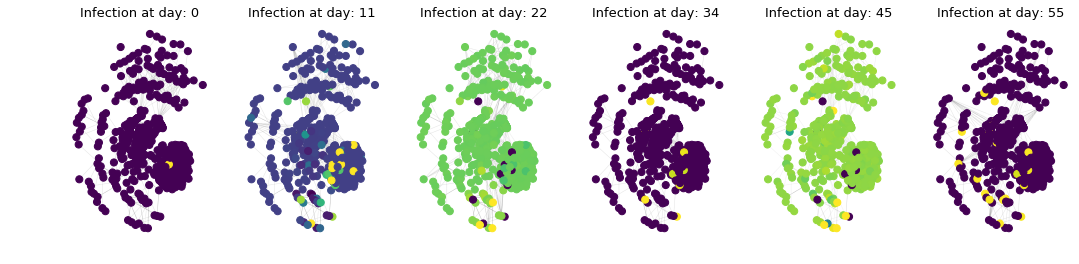

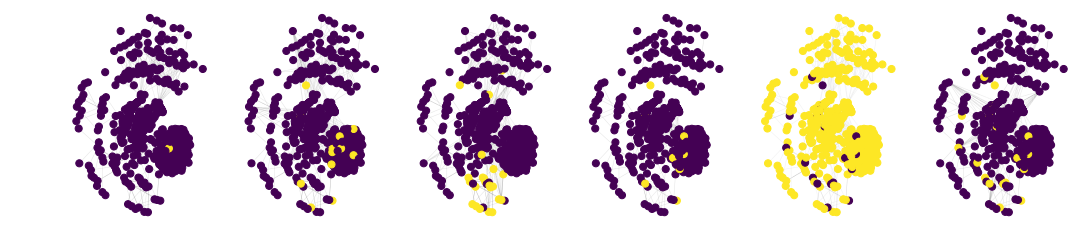

In [24]:
# Graph representation of the boolen signal over the aggregated laplacian

n_snapshots_to_print = 6
graph_diffusion_Lagg(L_agg, signal_time, bool_signal_time, n_snapshots_to_print, pos_agg)

# Evaluation and observations

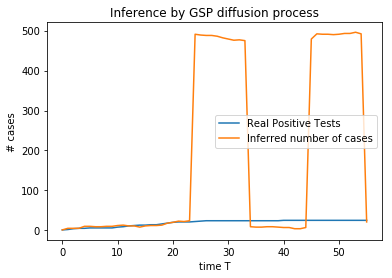

In [25]:
plt.plot(numer_of_known_cases_day_by_day, label="Real Positive Tests")
plt.plot([int(sum(x)) for x in bool_signal_time], label="Inferred number of cases")
plt.xlabel('time T')
plt.ylabel('# cases')
plt.title('Inference by GSP diffusion process')
plt.legend()
plt.show()

In [26]:
cases_comparison = pd.DataFrame(numer_of_known_cases_day_by_day, columns = ['real'])
cases_comparison['inferred'] = [int(sum(x)) for x in bool_signal_time]
cases_comparison

,real,inferred
0,1,1
1,2,5
2,4,5
3,5,5
4,5,10
5,6,10
6,6,9
7,6,9
8,6,10
9,6,10


As expected, forcing the phenomena to a diffusion process, it is clear that Covid tests are incomplete meaning that there is more people infected that has not been detected. Even if our tool depend on a synthetically cerated network and the starting point is random, just looking at numbers it come clear that the number of tests not only depend on the period (availability of tests) but also is never corresponding to the daily number of infected people. To have such a result in fact, there would be to test all population every day, and this is of course not realistic.

# Save Signals in file

In [ ]:
# Save the signals as list of signals in a .npy file

inferred_signal = [signal_time, bool_signal_time]
np.save("datasets/outputs/inferred_signal.npy", inferred_signal)

In [ ]:
# Save filter names and values of parameters Tau

inferred_filters_and_tau = [kind_of_filter, tau]
np.save("datasets/outputs/inferred_filters_and_tau.npy", np.array(inferred_filters_and_tau, dtype=object))